In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,LabelEncoder
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from prophet import Prophet
from datetime import timedelta
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
import warnings
warnings.filterwarnings("ignore")

C:\Users\TolgaKurt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def smape(y_true, y_pred):
    """
    SMAPE (Symmetric Mean Absolute Percentage Error) hesaplayan fonksiyon.
    
    Args:
    y_true (array-like): Gerçek değerler.
    y_pred (array-like): Tahmin edilen değerler.
    
    Returns:
    float: SMAPE değeri.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value

In [3]:
data = pd.read_excel(os.getcwd() + "/data/ODMD_MainData.xlsx")
data = data.sort_values(ascending=True,by="Date")
data.loc[data.MARKA == "KG MOBILITY – SSANGYONG",'MARKA'] = "SSANGYONG" 
## 0 olan satıs aylarını cıkar.
data = data[data.TOPLAM != 0]

In [4]:
data = data[["TOPLAM","Date","MARKA"]]

monthly_data = data[["Date","TOPLAM"]].groupby("Date").agg({"TOPLAM":"sum"}).reset_index()
monthly_data.head(5)

,Date,TOPLAM
0,2014-01-01,24368
1,2014-02-01,27167
2,2014-03-01,37812
3,2014-04-01,42769
4,2014-05-01,46379


In [5]:
## add month & Quarter features
monthly_data["Month"] = monthly_data.Date.dt.month
monthly_data["Quarter"] = monthly_data.Date.dt.quarter
monthly_data["Year"] = monthly_data.Date.dt.year


## Avg - Median & Total Sales by Month / Quarter / Year
month = monthly_data[["Month","TOPLAM"]].groupby("Month").agg(
    TotalSales = ("TOPLAM", np.sum),
    AvgSales = ("TOPLAM", np.mean),
    MedianSales = ("TOPLAM", np.median)
).reset_index(names="Month")

month["Month"] = month["Month"].astype("str")


quarter = monthly_data[["Quarter","TOPLAM"]].groupby("Quarter").agg(
    TotalSales = ("TOPLAM", np.sum),
    AvgSales = ("TOPLAM", np.mean),
    MedianSales = ("TOPLAM", np.median)
).reset_index(names="Quarter")

quarter["Quarter"] = quarter["Quarter"].astype("str")


year = monthly_data[["Year","TOPLAM"]].groupby("Year").agg(
    TotalSales = ("TOPLAM", np.sum),
    AvgSales = ("TOPLAM", np.mean),
    MedianSales = ("TOPLAM", np.median)
).reset_index(names="Year")

year["Year"] = year["Year"].astype("str")

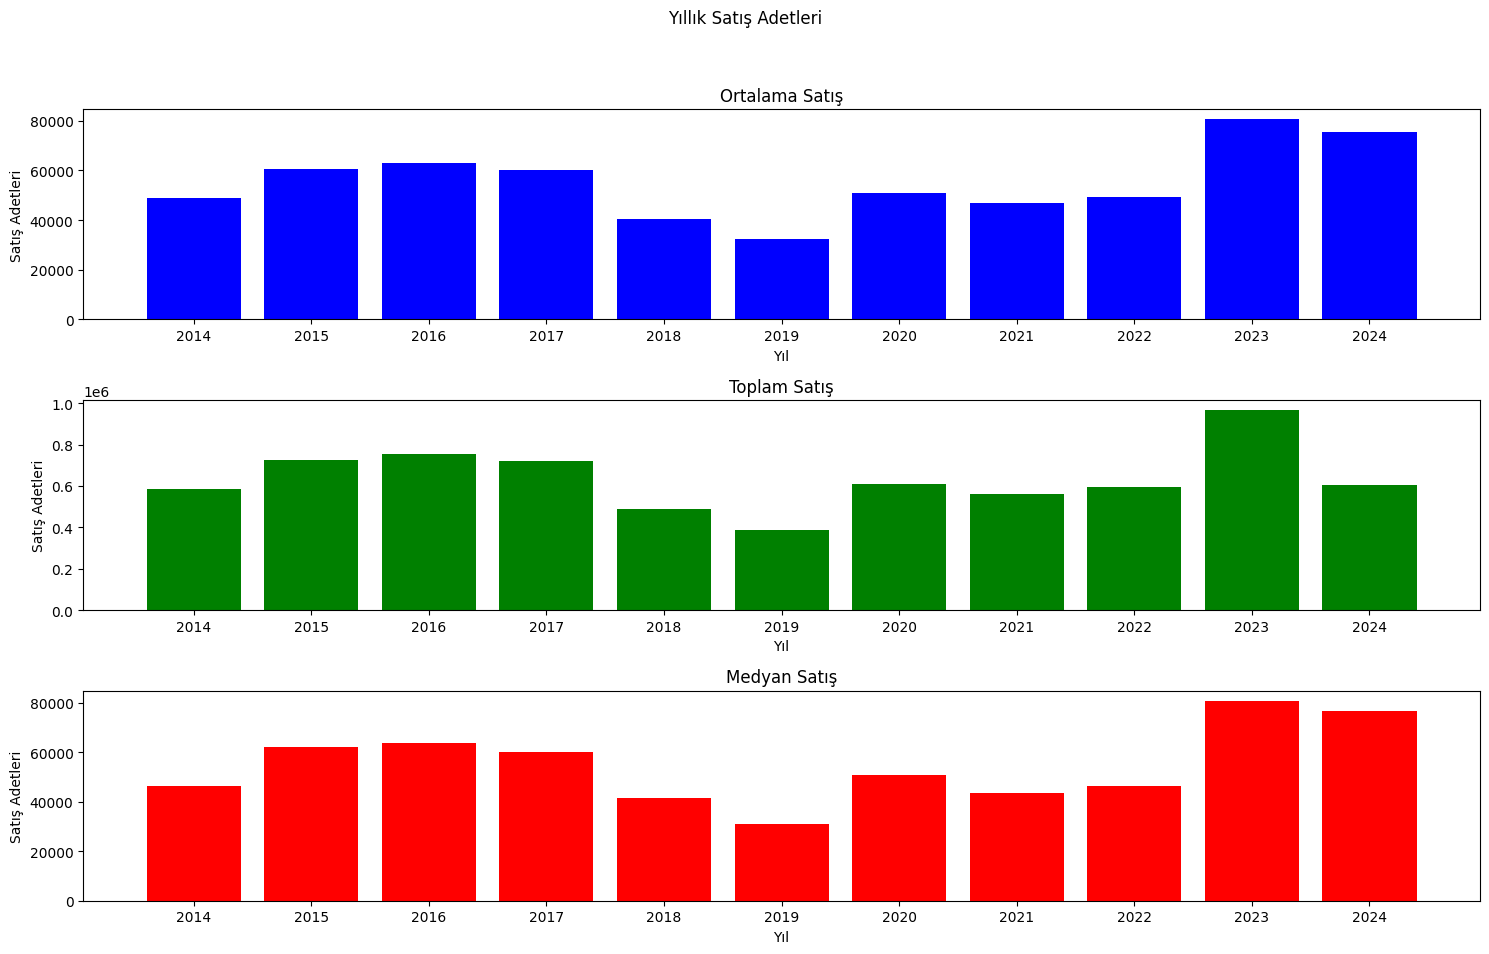

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

# Ortalama Satış çubukları
axs[0].bar(year["Year"], year["AvgSales"], color='b')
axs[0].set_title('Ortalama Satış')
axs[0].set_xlabel('Yıl')
axs[0].set_ylabel('Satış Adetleri')

# Toplam Satış çubukları
axs[1].bar(year["Year"], year["TotalSales"], color='g')
axs[1].set_title('Toplam Satış')
axs[1].set_xlabel('Yıl')
axs[1].set_ylabel('Satış Adetleri')

# Medyan Satış çubukları
axs[2].bar(year["Year"], year["MedianSales"], color='r')
axs[2].set_title('Medyan Satış')
axs[2].set_xlabel('Yıl')
axs[2].set_ylabel('Satış Adetleri')

# Grafik başlığı ve düzenlemeler
plt.suptitle('Yıllık Satış Adetleri')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Grafiği göster
plt.show()

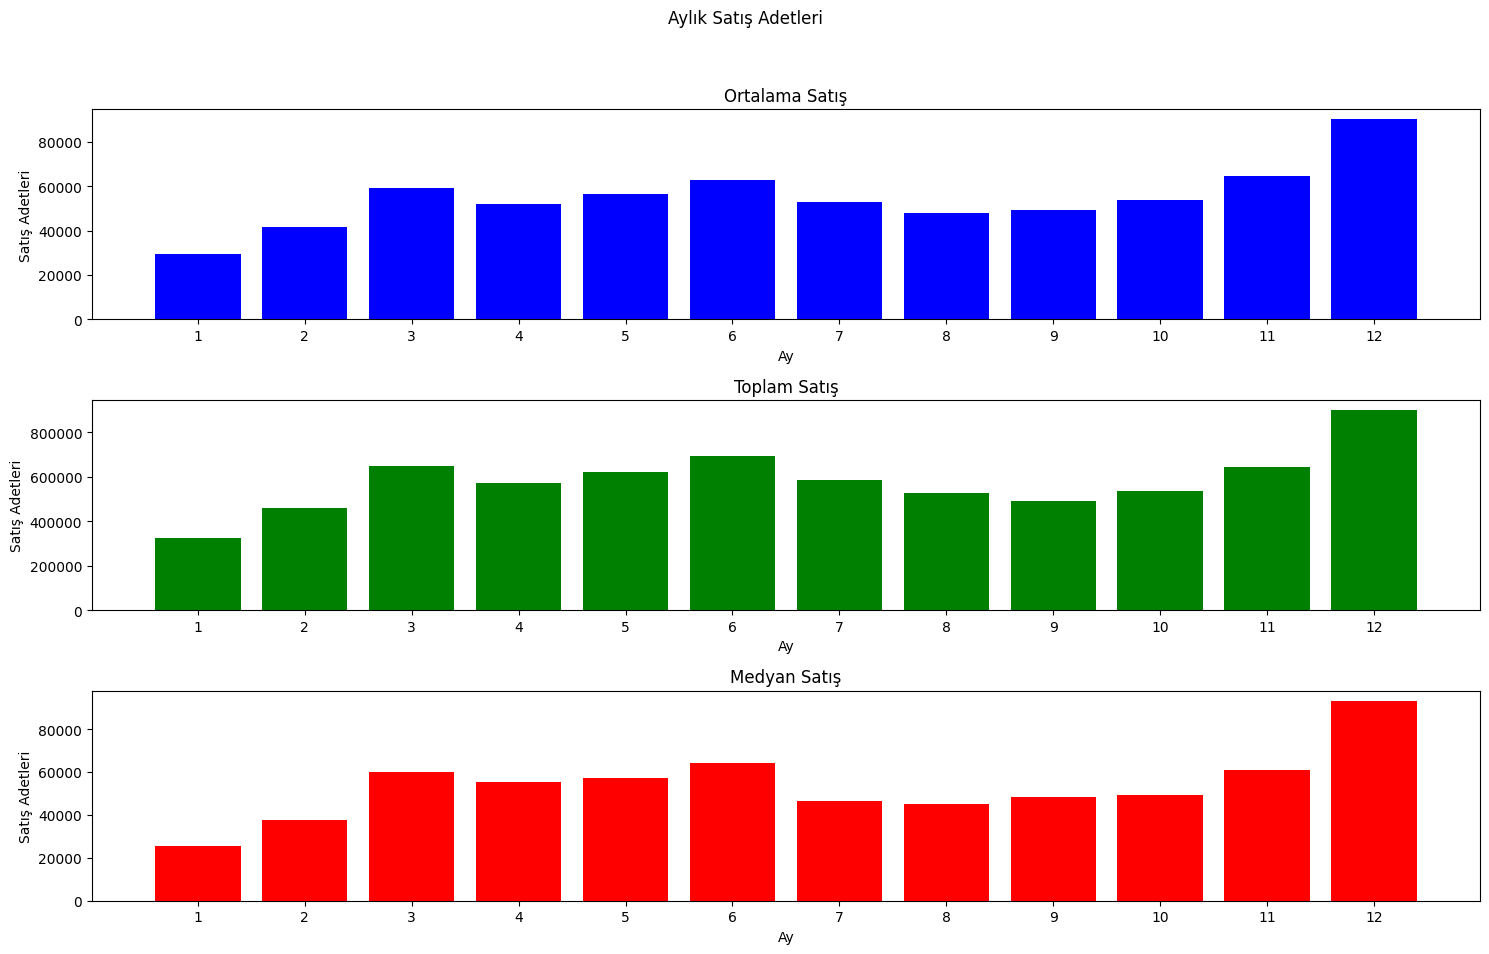

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

# Ortalama Satış çubukları
axs[0].bar(month["Month"], month["AvgSales"], color='b')
axs[0].set_title('Ortalama Satış')
axs[0].set_xlabel('Ay')
axs[0].set_ylabel('Satış Adetleri')

# Toplam Satış çubukları
axs[1].bar(month["Month"], month["TotalSales"], color='g')
axs[1].set_title('Toplam Satış')
axs[1].set_xlabel('Ay')
axs[1].set_ylabel('Satış Adetleri')

# Medyan Satış çubukları
axs[2].bar(month["Month"], month["MedianSales"], color='r')
axs[2].set_title('Medyan Satış')
axs[2].set_xlabel('Ay')
axs[2].set_ylabel('Satış Adetleri')

# Grafik başlığı ve düzenlemeler
plt.suptitle('Aylık Satış Adetleri')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Grafiği göster
plt.show()

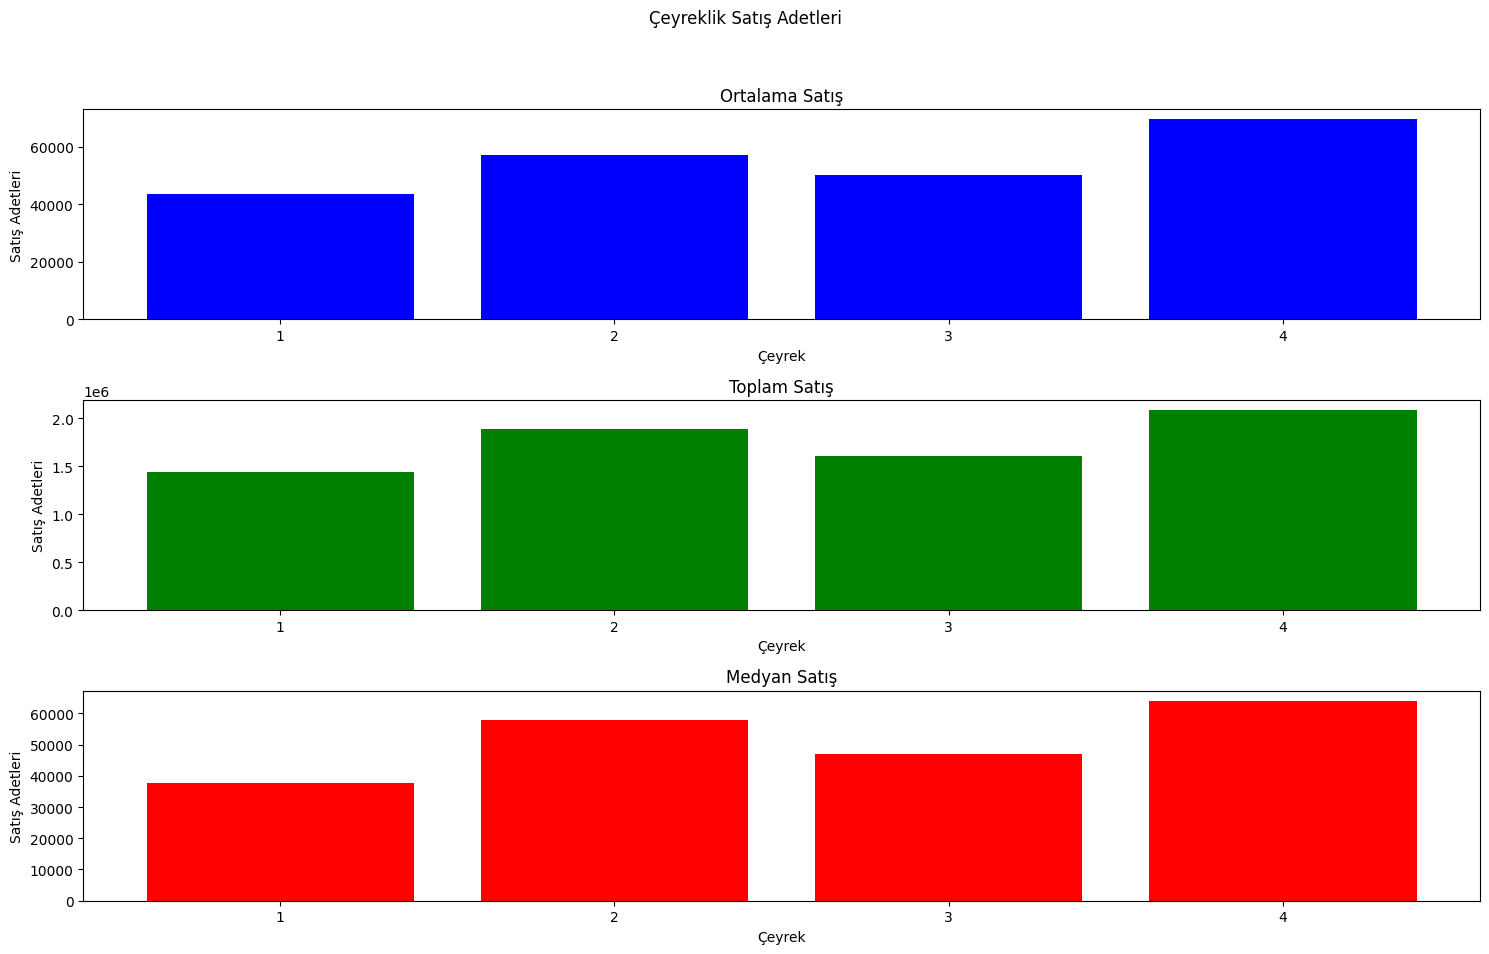

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

# Ortalama Satış çubukları
axs[0].bar(quarter["Quarter"], quarter["AvgSales"], color='b')
axs[0].set_title('Ortalama Satış')
axs[0].set_xlabel('Çeyrek')
axs[0].set_ylabel('Satış Adetleri')

# Toplam Satış çubukları
axs[1].bar(quarter["Quarter"], quarter["TotalSales"], color='g')
axs[1].set_title('Toplam Satış')
axs[1].set_xlabel('Çeyrek')
axs[1].set_ylabel('Satış Adetleri')

# Medyan Satış çubukları
axs[2].bar(quarter["Quarter"], quarter["MedianSales"], color='r')
axs[2].set_title('Medyan Satış')
axs[2].set_xlabel('Çeyrek')
axs[2].set_ylabel('Satış Adetleri')

# Grafik başlığı ve düzenlemeler
plt.suptitle('Çeyreklik Satış Adetleri')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Grafiği göster
plt.show()

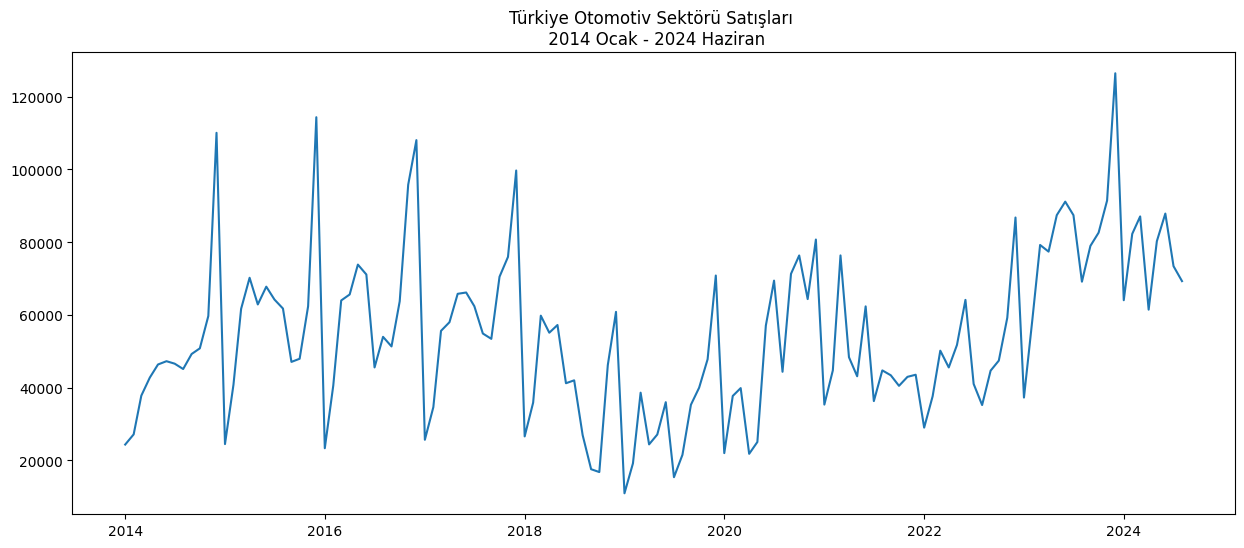

In [9]:
plt.figure(figsize=(15,6))
plt.plot(monthly_data["Date"],monthly_data["TOPLAM"])

plt.title("Türkiye Otomotiv Sektörü Satışları \n 2014 Ocak - 2024 Haziran")
plt.show()

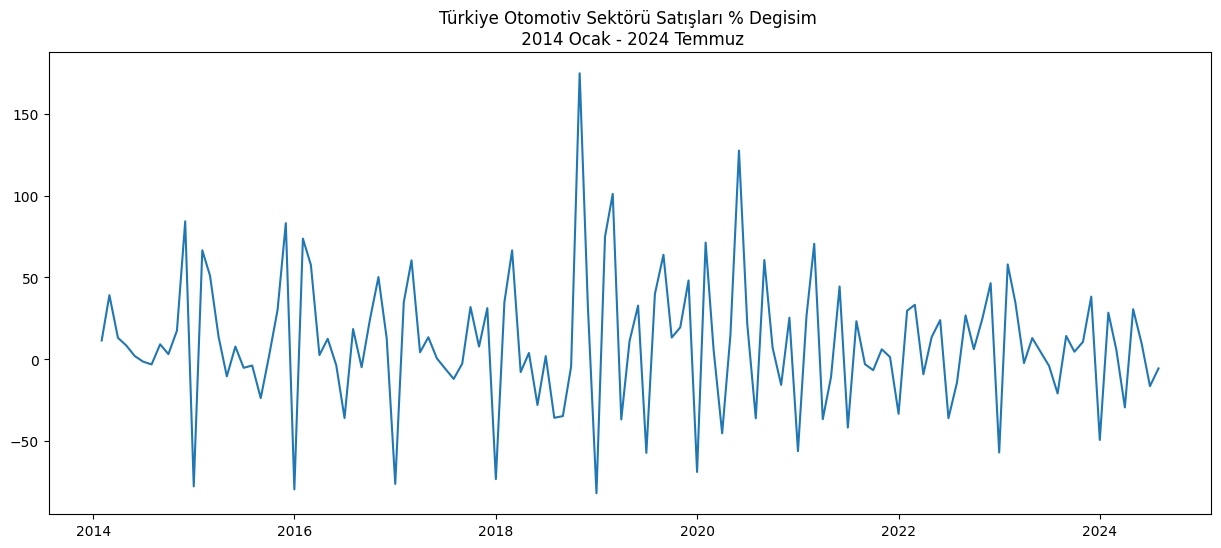

In [10]:
plt.figure(figsize=(15,6))
plt.plot(monthly_data["Date"],monthly_data["TOPLAM"].pct_change() * 100)

plt.title("Türkiye Otomotiv Sektörü Satışları % Degisim \n 2014 Ocak - 2024 Temmuz")
plt.show()

In [12]:
## get evds data
from evds_data import GetData

API_KEY = "API-KEY"

start_date = monthly_data["Date"].dt.date.min().strftime('%d-%m-%Y')
end_date = monthly_data["Date"].dt.date.max().strftime('%d-%m-%Y') 

ob = GetData(api_key= API_KEY,start_date= start_date , end_date = end_date)

eco_data = ob.request_evds()
eco_data.tail()

TP.KTF11-TP.FG.J071-TP.FG.J0-TP.BRENTPETROL.EUBP-TP.KREDI.L013-TP.GY9.N2.MA-TP.YISGUCU2.G2-TP.YISGUCU2.G8-TP.HKFE01-TP.BEK.S01.A.S-TP.BEK.S01.D.S-TP.TG2.Y01-TP.APIFON4-TP.TRY.MT02-TP.TG2.Y08-TP.TG2.Y09-TP.TG2.Y17-TP.UR.S08-TP.UR.S11-TP.KKM.K2-TP.DK.EUR.A.YTL-TP.DK.USD.A.YTL


,Tarih,Tasit_Kredi_Faiz_Oran,Arac_Satin_Alim_Tufe,Genel_Enflasyon_Tufe,EU_Brent_Petrol_Spot,Ticari_Bireysel_Kredi,Guven_Endeksi,Isgucu,Issizlik_Oran,Konut_Fiyat_Endeksi,...,DTM_Uygunluk,DTM_Harcama_Dusuncesi,Otomobil_Alma_Ihtimali,Otomobil_Uretim_Binek,Otomobil_Uretim_Kamyonet,KKM_Paralari_USD_Karsiligi,Euro_TL,USD_TL,TUFE_Change,Arac_Satin_Alim_Tufe_Change
123,2024-04-01,38.0575,1903.23,2207.50,88.23,6.644192e+09,92.9,35244.0,8.5,1257.6,...,47.108151,95.834394,17.830519,61835.0,28630.0,51.6,34.633211,32.271328,3.179759,1.332659
124,2024-05-01,37.4500,1961.85,2281.85,79.41,6.780748e+09,95.0,36004.0,7.7,1273.5,...,48.065050,95.594032,17.757170,91823.0,30125.0,48.9,34.782432,32.189895,3.368063,3.080027
125,2024-06-01,36.8550,1943.18,2319.29,87.26,6.928097e+09,92.7,35782.0,8.9,NaN,...,43.954371,94.049861,18.768351,68811.0,23094.0,45.7,34.981735,32.462747,1.640774,-0.951653
126,2024-07-01,53.7350,1959.28,2394.10,81.39,6.954457e+09,86.4,36102.0,9.3,NaN,...,44.842265,96.498011,19.446897,81434.0,25603.0,41.3,35.576541,32.835327,3.225556,0.828539
127,2024-08-01,52.4720,2000.42,2453.34,80.20,7.173661e+09,86.3,NaN,NaN,NaN,...,46.753978,94.269096,18.585425,NaN,NaN,NaN,36.906657,33.560781,2.474416,2.099751


In [13]:
## concat sales & eco features
sales_data = monthly_data.merge(eco_data,left_on="Date",right_on="Tarih",how="left").drop("Tarih",axis= 1)

In [14]:
sales_data.corr()

,TOPLAM,Month,Quarter,Year,Tasit_Kredi_Faiz_Oran,Arac_Satin_Alim_Tufe,Genel_Enflasyon_Tufe,EU_Brent_Petrol_Spot,Ticari_Bireysel_Kredi,Guven_Endeksi,...,DTM_Uygunluk,DTM_Harcama_Dusuncesi,Otomobil_Alma_Ihtimali,Otomobil_Uretim_Binek,Otomobil_Uretim_Kamyonet,KKM_Paralari_USD_Karsiligi,Euro_TL,USD_TL,TUFE_Change,Arac_Satin_Alim_Tufe_Change
TOPLAM,1.000000,0.418702,0.349152,0.165694,0.189375,0.394632,0.396499,-0.048869,0.418768,0.260121,...,0.146655,-0.001781,0.398348,0.345763,0.352710,0.795147,0.379338,0.379480,0.013686,-0.017981
Month,0.418702,1.000000,0.971296,-0.061023,0.020493,0.002580,-0.014611,-0.075765,-0.002279,0.010477,...,-0.069625,-0.086468,-0.113901,0.165877,0.196692,0.048193,0.002281,0.007267,-0.051328,0.048696
Quarter,0.349152,0.971296,1.000000,-0.058833,0.030328,0.003609,-0.012871,-0.071927,-0.001991,0.004685,...,-0.072455,-0.074518,-0.093628,0.132604,0.156182,0.055916,0.002969,0.008149,-0.022414,0.035263
Year,0.165694,-0.061023,-0.058833,1.000000,0.751212,0.843356,0.813059,0.283078,0.848101,-0.125426,...,-0.798258,-0.535320,0.409603,0.042906,-0.117369,0.765234,0.858024,0.854493,0.544713,0.191151
Tasit_Kredi_Faiz_Oran,0.189375,0.020493,0.030328,0.751212,1.000000,0.878723,0.871413,0.413483,0.855705,-0.262781,...,-0.495828,-0.280769,0.492189,0.086086,-0.083274,0.629842,0.880140,0.876657,0.518307,0.119972
Arac_Satin_Alim_Tufe,0.394632,0.002580,0.003609,0.843356,0.878723,1.000000,0.991156,0.426839,0.993691,-0.139295,...,-0.481430,-0.416881,0.612728,0.031535,-0.102263,0.787947,0.998108,0.997908,0.553997,0.162638
Genel_Enflasyon_Tufe,0.396499,-0.014611,-0.012871,0.813059,0.871413,0.991156,1.000000,0.397833,0.991691,-0.128951,...,-0.432095,-0.362103,0.646877,0.041149,-0.107697,0.720393,0.990258,0.990341,0.488812,0.109534
EU_Brent_Petrol_Spot,-0.048869,-0.075765,-0.071927,0.283078,0.413483,0.426839,0.397833,1.000000,0.383776,-0.143828,...,-0.207385,-0.232781,0.232634,-0.158824,-0.108214,-0.649176,0.426986,0.425644,0.428040,0.103800
Ticari_Bireysel_Kredi,0.418768,-0.002279,-0.001991,0.848101,0.855705,0.993691,0.991691,0.383776,1.000000,-0.113297,...,-0.465857,-0.383542,0.650685,0.047978,-0.095926,0.845770,0.993071,0.992592,0.501296,0.139803
Guven_Endeksi,0.260121,0.010477,0.004685,-0.125426,-0.262781,-0.139295,-0.128951,-0.143828,-0.113297,1.000000,...,0.304547,0.347237,0.255758,0.220575,0.220930,0.817137,-0.152116,-0.163299,-0.319519,-0.282125


In [15]:
columns = [
    "Date","TOPLAM","Month","Quarter","Year","Tasit_Kredi_Faiz_Oran",
    "Arac_Satin_Alim_Tufe","Genel_Enflasyon_Tufe","Ticari_Bireysel_Kredi","Otomobil_Alma_Ihtimali",
    "Issizlik_Oran","Konut_Fiyat_Endeksi","USD_TL","Faiz","Mevduat_Faizi"]


sales_data = sales_data[columns]
sales_data.head()

,Date,TOPLAM,Month,Quarter,Year,Tasit_Kredi_Faiz_Oran,Arac_Satin_Alim_Tufe,Genel_Enflasyon_Tufe,Ticari_Bireysel_Kredi,Otomobil_Alma_Ihtimali,Issizlik_Oran,Konut_Fiyat_Endeksi,USD_TL,Faiz,Mevduat_Faizi
0,2014-01-01,24368,1,1,2014,12.8400,151.68,233.54,639761215.0,15.112251,10.5,64.1,2.216836,9.96,9.0220
1,2014-02-01,27167,2,1,2014,15.0925,161.10,234.54,642644984.0,11.433624,10.5,64.8,2.212760,10.23,10.6275
2,2014-03-01,37812,3,1,2014,15.2100,166.94,237.18,647282258.0,11.333851,9.4,65.7,2.217795,10.27,11.3125
3,2014-04-01,42769,4,2,2014,14.9100,167.83,240.37,649650386.0,12.544490,8.8,66.8,2.127471,10.03,11.0200
4,2014-05-01,46379,5,2,2014,14.2880,166.66,241.32,662454414.0,15.565597,8.4,67.5,2.090805,9.53,10.4940


In [16]:
na_values = sales_data.isna().sum().reset_index()
na_values.columns = ["cols","na"]

for col in sales_data[na_values[na_values.na > 0].cols.values].columns:
    sales_data[col] = sales_data[col].interpolate()


In [17]:
sales_data["Genel_Enflasyon_Tufe_Change"] = sales_data["Genel_Enflasyon_Tufe"].pct_change() * 100
sales_data["Arac_Alim_Satim_Tufe_Change"] = sales_data["Arac_Satin_Alim_Tufe"].pct_change() * 100
sales_data["Ticari_Bireysel_Kredi_Change"] = sales_data["Ticari_Bireysel_Kredi"].pct_change() * 100
sales_data["Otomobil_Alma_Ihtimali_Change"] = sales_data["Otomobil_Alma_Ihtimali"].pct_change() * 100
sales_data["USD_TL_Change"] = sales_data["USD_TL"].pct_change() * 100
sales_data["Tasit_Kredi_Faiz_Oran_Change"] = sales_data["Tasit_Kredi_Faiz_Oran"].pct_change() * 100
sales_data["Faiz_Change"] = sales_data["Faiz"].pct_change() * 100
sales_data["Mevduat_Faizi_Change"] = sales_data["Mevduat_Faizi"].pct_change() * 100
sales_data["Konut_Fiyat_Endeksi_Change"] = sales_data["Konut_Fiyat_Endeksi"].pct_change() * 100

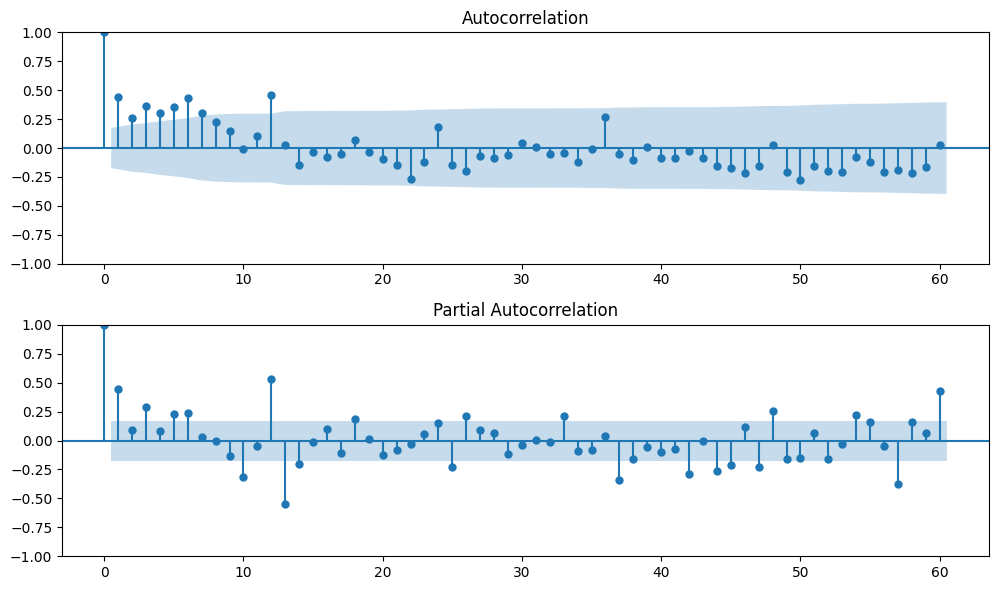

In [18]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
plot_acf(sales_data["TOPLAM"].dropna(),lags=60, ax=ax[0])
plot_pacf(sales_data["TOPLAM"].dropna(),lags=60, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

In [19]:
##Add shifted values
###TTL_TOPLAM -> 1,3,6,12
sales_data["Sales_L1"] = sales_data.TOPLAM.shift(1)
sales_data["Sales_L3"] = sales_data.TOPLAM.shift(3)
sales_data["Sales_L6"] = sales_data.TOPLAM.shift(6)
sales_data["Sales_L12"] = sales_data.TOPLAM.shift(12)

features = [
    "Genel_Enflasyon_Tufe_Change","Arac_Alim_Satim_Tufe_Change",
    "Ticari_Bireysel_Kredi_Change","Otomobil_Alma_Ihtimali_Change",
    "USD_TL_Change","Tasit_Kredi_Faiz_Oran_Change","Konut_Fiyat_Endeksi_Change","Faiz_Change","Mevduat_Faizi_Change"
    ]

for i in features:
    for j in [1,3]:
        sales_data[i+"_L{}".format(j)] = sales_data[i].shift(j)

In [20]:
sales_data["month_sin"] = np.sin(2 * np.pi * sales_data.Date.dt.month / 12)
sales_data["month_cos"] = np.cos(2 * np.pi * sales_data.Date.dt.month / 12)

## shifted sma features

sales_data["Shifted1_SMA3"] = sales_data["TOPLAM"].shift(1).rolling(3).mean()
sales_data["Shifted1_SMA6"] = sales_data["TOPLAM"].shift(1).rolling(6).mean()
sales_data["Shifted1_SMA12"] = sales_data["TOPLAM"].shift(1).rolling(12).mean()

In [21]:
old_data = sales_data

In [22]:
sales_data = sales_data.drop(features,axis=1)
sales_data = sales_data.drop([
    'Tasit_Kredi_Faiz_Oran', 'Arac_Satin_Alim_Tufe', 'Genel_Enflasyon_Tufe',
       'Ticari_Bireysel_Kredi', 'Otomobil_Alma_Ihtimali', 'Issizlik_Oran','USD_TL',
       "Konut_Fiyat_Endeksi","Faiz", "Mevduat_Faizi"],axis=1)
new_columns = sales_data.columns

In [23]:
##Create Future Dataset

forecasting_date = pd.to_datetime("2024-09-01")
forecasting_date_L1 = forecasting_date + pd.DateOffset(months= -1)
forecasting_date_L3 = forecasting_date + pd.DateOffset(months= -3)
forecasting_date_L6 = forecasting_date + pd.DateOffset(months= -6)
forecasting_date_L12 = forecasting_date + pd.DateOffset(months = -12)


## 1. gecikmeler
d = {}
for i in new_columns[new_columns.str.endswith("L1")]:
    col_name = i[0:-3]
    if col_name == "Sales":
        col_name = "TOPLAM"
    d[i] = old_data[old_data.Date == forecasting_date_L1][col_name].values.flatten()


## 3.gecikmeler
for i in new_columns[new_columns.str.endswith("L3")]:
    col_name = i[0:-3]
    if col_name == "Sales":
        col_name = "TOPLAM"
    d[i] = old_data[old_data.Date == forecasting_date_L3][col_name].values.flatten()


## 6.gecikmeler
for i in new_columns[new_columns.str.endswith("L6")]:
    col_name = i[0:-3]
    if col_name == "Sales":
        col_name = "TOPLAM"
    d[i] = old_data[old_data.Date == forecasting_date_L6][col_name].values.flatten()


## 12.gecikmeler
for i in new_columns[new_columns.str.endswith("L12")]:
    col_name = i[0:-4]
    if col_name == "Sales":
        col_name = "TOPLAM"
    d[i] = old_data[old_data.Date == forecasting_date_L12][col_name].values.flatten()



future_frame = pd.DataFrame(d)
future_frame["ds"] = forecasting_date
future_frame["Month"] = forecasting_date.month
future_frame["Year"] = forecasting_date.year
future_frame["Quarter"] = forecasting_date.quarter
future_frame["month_sin"] = np.sin(2 * np.pi * forecasting_date.month / 12)
future_frame["month_cos"] = np.cos(2 * np.pi * forecasting_date.month / 12)
future_frame['Shifted1_SMA3'] = sales_data['Shifted1_SMA3'].iloc[-3:].mean()
future_frame['Shifted1_SMA6'] = sales_data['Shifted1_SMA6'].iloc[-6:].mean()
future_frame['Shifted1_SMA12'] = sales_data['Shifted1_SMA12'].iloc[-12:].mean()

In [24]:
train_set = sales_data[sales_data.Date < '2023-11-01']
test_set = sales_data[sales_data.Date >= '2023-11-01']
X_Train = train_set.drop(["Date","TOPLAM"],axis = 1)
X_Test = test_set.drop(["Date","TOPLAM"],axis = 1)
y_train = train_set["TOPLAM"]
y_test = test_set["TOPLAM"]

In [25]:
iteration = range(100,600,100)
learning_rate = [.001,.01,.1,.2,.3,.5,.7,.85,.90]
depth = [2,4,6]
#l2_leaf_reg = [.1,.2,.3]


best_score = np.inf
best_params = {}

for i in iteration:
    for j in learning_rate:
        for k in depth:
                cb_model = CatBoostRegressor(iterations=i,learning_rate=j,depth=k,verbose=False,random_seed=42)
                cb_model.fit(X_Train,y_train)
                predict = cb_model.predict(X_Test)
                smape_score = smape(predict,y_test)
                #print(mae)

                if smape_score < best_score:
                    best_score = smape_score
                    best_params["iter"] = i
                    best_params["lr"] = j
                    best_params["depth"] = k
                    #best_params["l2_leaf"] = l
                    best_params["score"] = best_score


In [26]:
best_params


{'iter': 100, 'lr': 0.7, 'depth': 2, 'score': 10.913277347643021}

In [27]:
## Create CatBoost model for best parameters
cb_model = CatBoostRegressor(iterations=100,learning_rate=0.7,depth=2,verbose=False)
cb_model.fit(X_Train,y_train)
predict = cb_model.predict(X_Test)

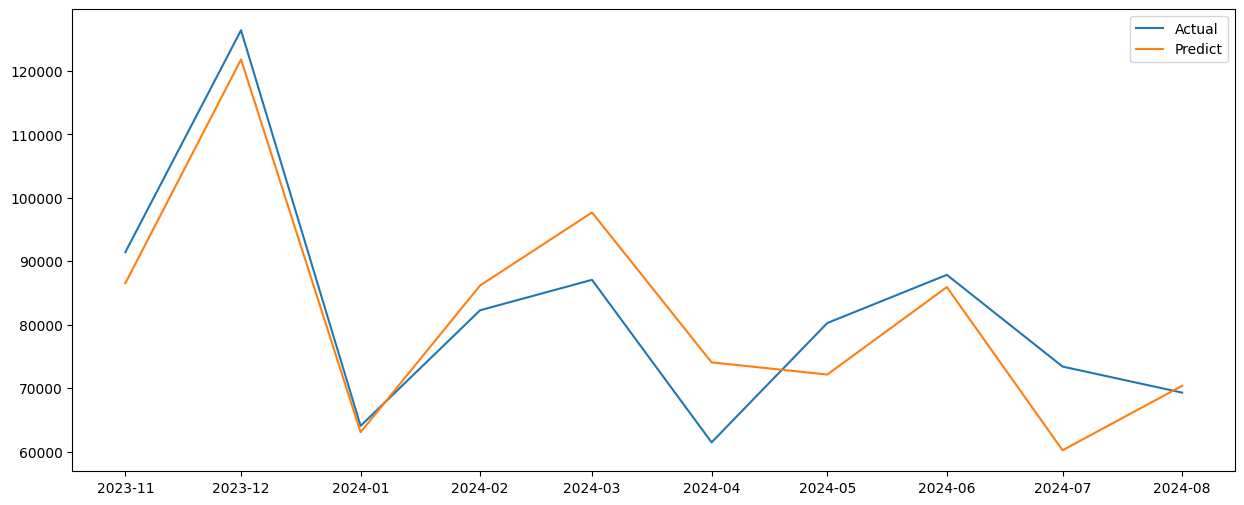

In [28]:
plt.figure(figsize=(15,6))
plt.plot(test_set.Date,y_test,label = "Actual")
plt.plot(test_set.Date,predict,label = "Predict")
plt.legend()
plt.show()

In [29]:
mean_absolute_error(y_true=y_test,y_pred=predict)

6195.843549144627

In [30]:
smape(y_true=y_test,y_pred=predict)

7.970143114730215

In [31]:
## Set all data for training
all_data_train = sales_data.drop(["Date","TOPLAM"],axis = 1)
all_data_y = sales_data.TOPLAM
all_data_train.head()

#scaler = MinMaxScaler()
#scaler.fit(all_data_train.fillna(0))
#X_Train = scaler.transform(X_Train)

,Month,Quarter,Year,Sales_L1,Sales_L3,Sales_L6,Sales_L12,Genel_Enflasyon_Tufe_Change_L1,Genel_Enflasyon_Tufe_Change_L3,Arac_Alim_Satim_Tufe_Change_L1,...,Konut_Fiyat_Endeksi_Change_L3,Faiz_Change_L1,Faiz_Change_L3,Mevduat_Faizi_Change_L1,Mevduat_Faizi_Change_L3,month_sin,month_cos,Shifted1_SMA3,Shifted1_SMA6,Shifted1_SMA12
0,1,1,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.500000,8.660254e-01,NaN,NaN,NaN
1,2,1,2014,24368.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.866025,5.000000e-01,NaN,NaN,NaN
2,3,1,2014,27167.0,NaN,NaN,NaN,0.428192,NaN,6.210443,...,NaN,2.710843,NaN,17.795389,NaN,1.000000,6.123234e-17,NaN,NaN,NaN
3,4,2,2014,37812.0,24368.0,NaN,NaN,1.125608,NaN,3.625078,...,NaN,0.391007,NaN,6.445542,NaN,0.866025,-5.000000e-01,29782.333333,NaN,NaN
4,5,2,2014,42769.0,27167.0,NaN,NaN,1.344970,0.428192,0.533126,...,1.092044,-2.336904,2.710843,-2.585635,17.795389,0.500000,-8.660254e-01,35916.000000,NaN,NaN


In [34]:
#### Create model for all data

cb_model = CatBoostRegressor(iterations=100,learning_rate=0.7,depth=2,verbose=False)#CatBoostRegressor(iterations=500,learning_rate=0.85,depth=2,fold_len_multiplier=2.5,l2_leaf_reg= 0.3)
cb_model.fit(all_data_train,all_data_y)

predict_cb = cb_model.predict(future_frame[all_data_train.columns])

In [35]:
predict_cb

array([61538.87105516])

In [36]:
## set train & test set for arima

train_set = train_set.set_index(train_set.Date)
train_set = train_set.asfreq('MS')
train_set = train_set.sort_index()

test_set = test_set.set_index(test_set.Date)
test_set = test_set.asfreq('MS')
test_set = test_set.sort_index()

exog_cols = ['Month', 'Quarter', 'Year', 'Sales_L1',
       'Sales_L3', 'Sales_L6', 'Sales_L12', 'Genel_Enflasyon_Tufe_Change_L1',
       'Genel_Enflasyon_Tufe_Change_L3', 'Arac_Alim_Satim_Tufe_Change_L1',
       'Arac_Alim_Satim_Tufe_Change_L3', 'Ticari_Bireysel_Kredi_Change_L1',
       'Ticari_Bireysel_Kredi_Change_L3', 'Otomobil_Alma_Ihtimali_Change_L1',
       'Otomobil_Alma_Ihtimali_Change_L3', 'USD_TL_Change_L1',
       'USD_TL_Change_L3', 'Tasit_Kredi_Faiz_Oran_Change_L1',
       'Tasit_Kredi_Faiz_Oran_Change_L3', 'Konut_Fiyat_Endeksi_Change_L1',
       'Konut_Fiyat_Endeksi_Change_L3',"Faiz_Change_L1","Faiz_Change_L3","Mevduat_Faizi_Change_L1",
       "Mevduat_Faizi_Change_L3",'month_sin', 'month_cos',"Shifted1_SMA3","Shifted1_SMA6","Shifted1_SMA12"]

X_Train = train_set.drop(["Date","TOPLAM"],axis= 1 )
X_Test = test_set.drop(["Date","TOPLAM"],axis= 1 )
y_train = train_set["TOPLAM"]
y_test = test_set["TOPLAM"]

In [37]:
new_columns = sales_data.columns

In [38]:
t = test_set[new_columns].reset_index(drop = True)
t = t.rename(columns={"Date":"ds","TOPLAM":"y"})
t_y = t[["y"]]
t_y.columns = ["y"]

In [39]:
a = sales_data.isna().sum().reset_index()
a.columns = ["column","NA"]

In [40]:
from prophet import Prophet
f = train_set.reset_index(drop= True)
f = f[new_columns]
f = f.rename(columns={"Date":"ds","TOPLAM":"y"})

for j in a[a.NA > 0]["column"].values:
    f[j] = f[j].fillna(0)


m = Prophet(interval_width=0.95,changepoint_prior_scale=0.0001,changepoint_range=0.5)
m.add_seasonality(name='monthly', period=60.5, fourier_order=2,prior_scale=0.3)


for i in [x for x in exog_cols if x not in exog_cols[-5:-3]]:
    print(i," added in Prophet Model.")
    m.add_regressor(i,standardize=True,mode='additive')

m.add_regressor("month_sin",standardize=False,mode='additive')
m.add_regressor("month_cos",standardize=False,mode='additive')

m.fit(f)
#forecast = m.predict(t_p)  

11:13:26 - cmdstanpy - INFO - Chain [1] start processing
11:13:26 - cmdstanpy - INFO - Chain [1] done processing
11:13:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:13:26 - cmdstanpy - INFO - Chain [1] start processing


Month  added in Prophet Model.
Quarter  added in Prophet Model.
Year  added in Prophet Model.
Sales_L1  added in Prophet Model.
Sales_L3  added in Prophet Model.
Sales_L6  added in Prophet Model.
Sales_L12  added in Prophet Model.
Genel_Enflasyon_Tufe_Change_L1  added in Prophet Model.
Genel_Enflasyon_Tufe_Change_L3  added in Prophet Model.
Arac_Alim_Satim_Tufe_Change_L1  added in Prophet Model.
Arac_Alim_Satim_Tufe_Change_L3  added in Prophet Model.
Ticari_Bireysel_Kredi_Change_L1  added in Prophet Model.
Ticari_Bireysel_Kredi_Change_L3  added in Prophet Model.
Otomobil_Alma_Ihtimali_Change_L1  added in Prophet Model.
Otomobil_Alma_Ihtimali_Change_L3  added in Prophet Model.
USD_TL_Change_L1  added in Prophet Model.
USD_TL_Change_L3  added in Prophet Model.
Tasit_Kredi_Faiz_Oran_Change_L1  added in Prophet Model.
Tasit_Kredi_Faiz_Oran_Change_L3  added in Prophet Model.
Konut_Fiyat_Endeksi_Change_L1  added in Prophet Model.
Konut_Fiyat_Endeksi_Change_L3  added in Prophet Model.
Faiz_Ch

11:13:57 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
forecast = m.predict(t.drop(["y"],axis = 1))

In [43]:
from prophet.plot import plot_plotly
import plotly.offline as py 

fig = plot_plotly(m,forecast)
py.iplot(fig)

In [44]:
forecast["yhat"]

0     93338.615198
1    120345.133405
2     54913.550606
3     65297.412398
4     90634.995207
5     68289.068073
6     88011.158529
7     99845.414040
8     77540.724085
9     59375.445524
Name: yhat, dtype: float64

In [45]:
y_test

Date
2023-11-01     91424
2023-12-01    126416
2024-01-01     64041
2024-02-01     82277
2024-03-01     87071
2024-04-01     61448
2024-05-01     80260
2024-06-01     87858
2024-07-01     73396
2024-08-01     69288
Freq: MS, Name: TOPLAM, dtype: int64

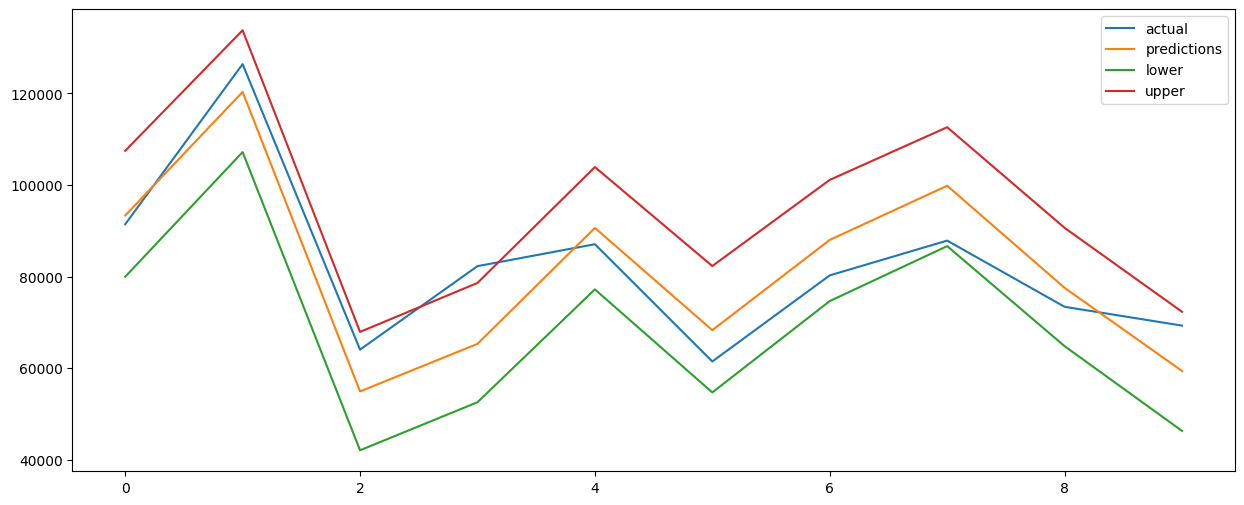

In [46]:
plt.figure(figsize=(15,6))
plt.plot(np.array(y_test), label='actual')
plt.plot(forecast["yhat"], label='predictions')
plt.plot(forecast["yhat_lower"], label='lower')
plt.plot(forecast["yhat_upper"], label='upper')
plt.legend()
plt.show()

In [47]:
smape(y_true=y_test,y_pred=forecast["yhat"])

10.279371235268336

In [48]:
### Tum veri ile modeli kur

## Sonraki ay verisinin oluşturulması
t = test_set[new_columns].reset_index(drop = True)
t = t.rename(columns={"Date":"ds","TOPLAM":"y"})
t_y = t[["y"]]
t_y.columns = ["y"]


from prophet import Prophet
f = sales_data.reset_index(drop= True)
f = f[new_columns]
f = f.rename(columns={"Date":"ds","TOPLAM":"y"})

for j in a[a.NA > 0]["column"].values:
    f[j] = f[j].fillna(f[j].mean())

m = Prophet(interval_width=0.5,changepoint_prior_scale=0.0001,changepoint_range=0.5)
m.add_seasonality(name='monthly', period=60.5, fourier_order=2,prior_scale=0.3)

#m.add_seasonality(name='monthly', period=60.5, fourier_order=5,prior_scale=0.75)

for i in  [x for x in exog_cols if x not in exog_cols[-5:-3]]:
    m.add_regressor(i,standardize=True,mode='additive')
    print(i," Added Prophet")


m.add_regressor("month_sin",standardize=False,mode='additive')
m.add_regressor("month_cos",standardize=False,mode='additive')


m.fit(f)

pred_prophet = m.predict(future_frame)




11:16:00 - cmdstanpy - INFO - Chain [1] start processing
11:16:00 - cmdstanpy - INFO - Chain [1] done processing
11:16:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:16:00 - cmdstanpy - INFO - Chain [1] start processing


Month  Added Prophet
Quarter  Added Prophet
Year  Added Prophet
Sales_L1  Added Prophet
Sales_L3  Added Prophet
Sales_L6  Added Prophet
Sales_L12  Added Prophet
Genel_Enflasyon_Tufe_Change_L1  Added Prophet
Genel_Enflasyon_Tufe_Change_L3  Added Prophet
Arac_Alim_Satim_Tufe_Change_L1  Added Prophet
Arac_Alim_Satim_Tufe_Change_L3  Added Prophet
Ticari_Bireysel_Kredi_Change_L1  Added Prophet
Ticari_Bireysel_Kredi_Change_L3  Added Prophet
Otomobil_Alma_Ihtimali_Change_L1  Added Prophet
Otomobil_Alma_Ihtimali_Change_L3  Added Prophet
USD_TL_Change_L1  Added Prophet
USD_TL_Change_L3  Added Prophet
Tasit_Kredi_Faiz_Oran_Change_L1  Added Prophet
Tasit_Kredi_Faiz_Oran_Change_L3  Added Prophet
Konut_Fiyat_Endeksi_Change_L1  Added Prophet
Konut_Fiyat_Endeksi_Change_L3  Added Prophet
Faiz_Change_L1  Added Prophet
Faiz_Change_L3  Added Prophet
Mevduat_Faizi_Change_L1  Added Prophet
Mevduat_Faizi_Change_L3  Added Prophet
Shifted1_SMA3  Added Prophet
Shifted1_SMA6  Added Prophet
Shifted1_SMA12  Added

11:16:01 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
pred_prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Arac_Alim_Satim_Tufe_Change_L1,Arac_Alim_Satim_Tufe_Change_L1_lower,Arac_Alim_Satim_Tufe_Change_L1_upper,Arac_Alim_Satim_Tufe_Change_L3,...,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-09-01,72711.591495,77230.288892,87245.084671,72711.591495,72711.591495,-72.664938,-72.664938,-72.664938,-3799.56898,...,4271.37096,4271.37096,4271.37096,31100.289158,31100.289158,31100.289158,0.0,0.0,0.0,82383.931068


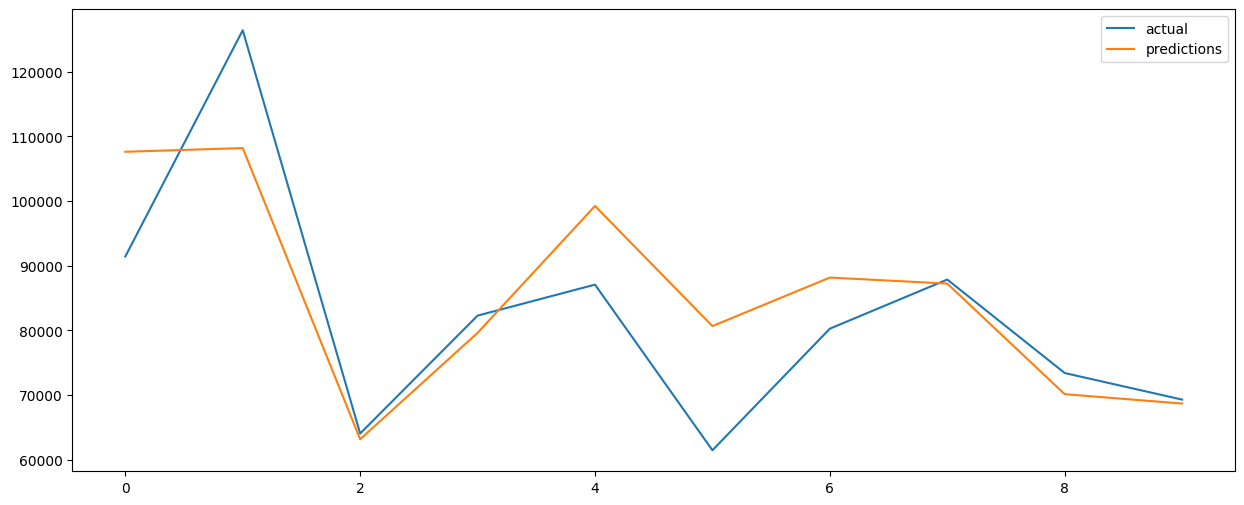

SMAPE :  9.213848933555084
MAE :  8176.05604998786


In [50]:
gbrt = HistGradientBoostingRegressor(loss="quantile",quantile=0.75,learning_rate=.9,max_bins=15,max_depth=1,l2_regularization=0.9).fit(X_Train,y_train)
pred = gbrt.predict(X_Test)

plt.figure(figsize=(15,6))
plt.plot(np.array(y_test), label='actual')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()


print("SMAPE : ",smape(y_true=y_test,y_pred=pred))

print("MAE : ",mean_absolute_error(y_true=y_test,y_pred=pred))


In [51]:
d = pd.DataFrame(test_set["TOPLAM"])

d["Pred"] = pred

In [52]:
gbrt_all = HistGradientBoostingRegressor(loss="quantile",quantile=0.75,learning_rate=.9,max_bins=15,max_depth=1,l2_regularization=0.9).fit(all_data_train,all_data_y)
pred_gbrt = gbrt.predict(future_frame[all_data_train.columns])
pred_gbrt

array([75119.17515548])

In [56]:
(pred_prophet["yhat"] + pred_gbrt + predict_cb) / 3

0    73013.992426
Name: yhat, dtype: float64

In [60]:
(pred_prophet["yhat"] + pred_gbrt) / 2

0    78751.553112
Name: yhat, dtype: float64

In [54]:
pred_gbrt

array([75119.17515548])

In [59]:
pred_prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Arac_Alim_Satim_Tufe_Change_L1,Arac_Alim_Satim_Tufe_Change_L1_lower,Arac_Alim_Satim_Tufe_Change_L1_upper,Arac_Alim_Satim_Tufe_Change_L3,...,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-09-01,72711.591495,77230.288892,87245.084671,72711.591495,72711.591495,-72.664938,-72.664938,-72.664938,-3799.56898,...,4271.37096,4271.37096,4271.37096,31100.289158,31100.289158,31100.289158,0.0,0.0,0.0,82383.931068


In [58]:
predict_cb

array([61538.87105516])

In [ ]:
#### 2024 Eylül

# CatBoost
### 2024 Eylül için tahmin : 61538.87105516

# HistogramGradiantBoosting
### 2024 Eylül için tahmin : 75119.17515548

# Prophet
### 2024 Eylül için tahmin : 82383.931068
### 2024 Eylül Alt sınır 77230.288892
### 2024 Eylül Üst sınır 87245.084671

## Eylül 3 Model Ortalaması : 73013.992426
## Eylül 2 Model Ortalaması (Prophet & HGBRT) : 78751.553112
###### 2024 Eylül Gerceklesen : 